In [107]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import time
from google.colab import output
from matplotlib.pyplot import figure
from music21 import * #Documentacao em https://web.mit.edu/music21/
from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

# Parâmetros gerais

In [108]:
from google.colab import drive
drive.mount('/content/drive')

#músicas = "drive/MyDrive/ML_ProjetoFinal"
músicas = "drive/MyDrive/MIDI_beethoven" #Pasta que contém o dataset original
gerações = '/content/drive/MyDrive/MIDI-Resultante/' #Pasta onde serão armazenados os arquivos gerados

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funções auxiliares

### Diretorio: Retorna uma lista dos arquivos em um diretório.

In [109]:
def Diretorio(gerações):
  return glob.glob(f"{gerações}/*.mid")

### Plotar: Utilizada para plotar em escala linear ou logarítmica as perdas e acurácia.

In [110]:
def Plotar(escala, disc_loss, gen_loss, acuracia):
    if (escala == 'linear'):
        plt.plot(disc_loss, c='red')
        plt.plot(gen_loss, c='blue')  
    else:
        if (escala == 'log'):
            plt.plot(np.log10(disc_loss), c='red')
            plt.plot(np.log10(gen_loss), c='blue')  
        else:
            print('Este método aceita apenas escala \'linear\' ou \'log\'.')
    plt.title("Perda por epoca")
    plt.legend(['Discriminador', 'Gerador'])
    plt.xlabel('Epoca')
    plt.ylabel('Perda')
    plt.show()
    
    plt.plot(acuracia, c='blue')
    plt.title("Acuracia Discriminador")
    plt.xlabel('Epoca')
    plt.ylabel('Acuracia')
    plt.show()
    plt.close()

### ReportarProgresso: Durante o treinamento, retorna em tempo real ("online") os valores de perda e acurácia, bem como a época em treinamento e o tempo estimado até o fim do mesmo.

In [111]:
def ReportarProgresso(epoch, epochs, d_loss, g_loss, start_time):
    tempo = time.strftime('%H:%M:%S', time.gmtime(((time.time() - start_time)*(epochs - epoch))))
    output.clear(wait=True)
    print("%d / %d [Perda Discriminador: %f, Acurácia: %.2f%%] [Perda Gerador: %f]" % (epoch + 1, epochs, d_loss[0], 100 * d_loss[1], g_loss))
    print("Tempo restante: %s " % tempo)

# Pré-processamento dos arquivos MIDI

### ObterNotas: Retorna as notas de um único arquivo MIDI.

In [112]:
def ObterNotas(arquivo):
  notas = []
  midi = converter.parse(arquivo)
  for element in midi.flat.elements:
      if isinstance(element, note.Rest) and element.offset != 0:
          notas.append('R')
      if isinstance(element, note.Note):
          notas.append(str(element.pitch))
      if isinstance(element, chord.Chord):
          notas.append('.'.join(str(pitch) for pitch in element.pitches))
  return notas

### CriarDicionario: Converte um conjunto de notas em uma codificação numérica.

In [113]:
def CriarDicionario(conjunto_de_notas):
  quantas_notas = len(conjunto_de_notas)
  codificacao_notas = dict((note, number) for number, note in enumerate(conjunto_de_notas))
  return quantas_notas, codificacao_notas

### Preparação das sequências para o treinamento.

In [114]:
def NormalizarSequencia(seq_treino, quantas_notas):
    seq_treino = np.array(seq_treino)
    seq_treino = (seq_treino - float(quantas_notas) / 2) / (float(quantas_notas) / 2)
    return seq_treino

In [115]:
def PrepararSequencias(notas_no_dataset, tam_sequencia, codificacao_notas, quantas_notas):
    seq_treino = []
    for notas in notas_no_dataset:
        numero_de_sequencias = len(notas) - tam_sequencia 
        for i in range(numero_de_sequencias):
            inicio = i
            fim = i + tam_sequencia
            seq_treino.append([codificacao_notas[note] for note in notas[inicio : fim]])
    seq_treino = NormalizarSequencia(seq_treino, quantas_notas)
    return seq_treino

In [116]:
def Criar_MIDI(prediction_output, filename):
    offset = 0
    midi_stream = stream.Stream()

    for pattern in prediction_output:
        # rest
        if pattern == 'R':
            midi_stream.append(note.Rest())
        # chord
        elif ('.' in str(pattern)) or str(pattern).isdigit():
            notas_no_acorde = pattern.split('.')
            notes = []
            for current_note in notas_no_acorde:  
                nova_nota = note.Note(current_note)
                nova_nota.storedInstrument = instrument.Piano()
                notes.append(nova_nota)
            novo_acorde = chord.Chord(notes)
            novo_acorde.offset = offset
            midi_stream.append(novo_acorde)
        # note
        else:
            nova_nota = note.Note(pattern)
            nova_nota.offset = offset
            nova_nota.storedInstrument = instrument.Piano()
            midi_stream.append(nova_nota)

        # Aumentar o offset a cada iteração para não empilhar notas
        offset += 0.5
    midi_stream.write('midi', fp=f'{filename}.mid')

# Definições de classes e métodos para o treinamento

### Especificação dos modelos sequenciais de gerador e discriminador.

In [117]:
def ConstruirGerador(latent_dim, seq_shape):
    model = Sequential()
    model.add(LSTM(512, input_shape=(latent_dim, 1), return_sequences=True))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(seq_shape), activation='tanh'))
    model.add(Reshape(seq_shape))

    noise = Input(shape=(latent_dim, 1))
    seq = model(noise)

    return Model(noise, seq)

def ConstruirDiscriminador(seq_shape):
    model = Sequential()
    model.add(LSTM(512, input_shape=seq_shape, return_sequences=True))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    seq = Input(shape=seq_shape)
    validity = model(seq)

    return Model(seq, validity)

### Métodos para geração de arquivos MIDI novos.

In [118]:
def Gerar(nome_do_arquivo, latent_dim, gerador, codificacao_notas):

    ruido = GerarRuido(latent_dim)
    predictions = gerador.predict(ruido)
    pred_notes = Decodificar(codificacao_notas, predictions)
        
    # generate music with .midi format
    if not os.path.exists(gerações):
        os.makedirs(gerações)

    Criar_MIDI(pred_notes, gerações + nome_do_arquivo)

In [119]:
def GerarRuido(latent_dim):
    return np.random.normal(0, 1, (1, latent_dim))

In [120]:
def Decodificar(codificacao_notas, predictions):
    boundary = int(len(codificacao_notas) / 2)
    pred_nums = [x * boundary + boundary for x in predictions[0]]
    notes = [key for key in codificacao_notas]
    pred_notes = [notes[int(x)] for x in pred_nums]
    return pred_notes

### Classes

In [121]:
class MIDI():
    def __init__(self, tam_sequencia):
        self.tam_sequencia = tam_sequencia
        self.notas_no_dataset = []
        self.seq_treino = []
        self.codificacao_notas = dict()
        self.quantas_notas = 0
        self.quantas_notas_arquivos = []

    def ObterNotasDataset(self, gerações):
        for arquivo in Diretorio(gerações):
            notas = ObterNotas(arquivo)
            self.notas_no_dataset.append(notas)
            self.quantas_notas_arquivos.append(len(notas))
        conjunto_de_notas = sorted(set(note for notas in self.notas_no_dataset for note in notas))
        dicionario = CriarDicionario(conjunto_de_notas)
        self.quantas_notas = dicionario[0];
        self.codificacao_notas = dicionario[1];

In [122]:
class MODEL():
  def __init__(self, midi_obj, dimensao_latente):
    self.midi = midi_obj
    self.tam_sequencia = self.midi.tam_sequencia
    self.seq_shape = (self.tam_sequencia, 1)
    self.latent_dim = dimensao_latente
    self.disc_loss = []
    self.gen_loss = []
    self.acuracia = []

    optimizer = Adam(0.0002, 0.5)

    # Construir e compilar o Discriminador
    self.discriminador = ConstruirDiscriminador(self.seq_shape)
    self.discriminador.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Construir o Gerador
    self.gerador = ConstruirGerador(self.latent_dim, self.seq_shape)

    # O gerador toma ruído como entrada e converte em uma sequencia de notas musicais.
    z = Input(shape=(self.latent_dim, 1))
    generated_seq = self.gerador(z)

    # No modelo "combinado" apenas o gerador é treinado, porém ambos gerador e discriminador são treinados.
    self.discriminador.trainable = False

    # O discriminador realiza a classificacao entre dados reais e sintéticos
    validity = self.discriminador(generated_seq)

    # O modelo combinado (gerador e discriminador acoplados) treina o gerador para enganar o discriminador.
    self.combinado = Model(z, validity)
    self.combinado.compile(loss='binary_crossentropy', optimizer=optimizer)

  def Treinar(self, epochs, músicas, batch_size, intervalo_amostragem):
    # Carregar os dados
    notes = midi.ObterNotasDataset(músicas)

    print("Preparando Sequências para treinamento...")

    sequences = PrepararSequencias(midi.notas_no_dataset, self.tam_sequencia, midi.codificacao_notas, midi.quantas_notas)

    print(f"\nNúmero de sequencias para treinamento: {sequences.shape[0]}\n")

    treinar_discriminador = True
    treinar_gerador = True

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
      start_time = time.time()
      index_seqs = np.random.randint(0, sequences.shape[0], batch_size)
      real_seqs = sequences[index_seqs]

      # Ruido aleatorio para o gerador
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Generate a batch of new note sequences
      gen_seqs = self.gerador.predict(noise)

      # Treinamento do discriminador
      if (treinar_discriminador):      
        d_loss_real = self.discriminador.train_on_batch(real_seqs, real)
        d_loss_fake = self.discriminador.train_on_batch(gen_seqs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #  Treinamento do gerador
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      if (treinar_gerador):
        g_loss = self.combinado.train_on_batch(noise, real)

      if (d_loss[0] < 0.7*g_loss):
          if (treinar_discriminador):
              treinar_discriminador = False
      else: treinar_discriminador = True
    
      if (g_loss < 0.7*d_loss[0]):
          if (treinar_gerador):
            treinar_gerador = False
      else: treinar_gerador = True    

      # Report do progresso
      if epoch % intervalo_amostragem == 0:
          ReportarProgresso(epoch, epochs, d_loss, g_loss, start_time)
          self.disc_loss.append(d_loss[0])
          self.gen_loss.append(g_loss)
          self.acuracia.append(100 * d_loss[1])

# Treinamento

### Modelo A - Baseline

300 / 300 [Perda Discriminador: 0.003448, Acurácia: 99.83%] [Perda Gerador: 6.065564]
Tempo restante: 00:00:04 


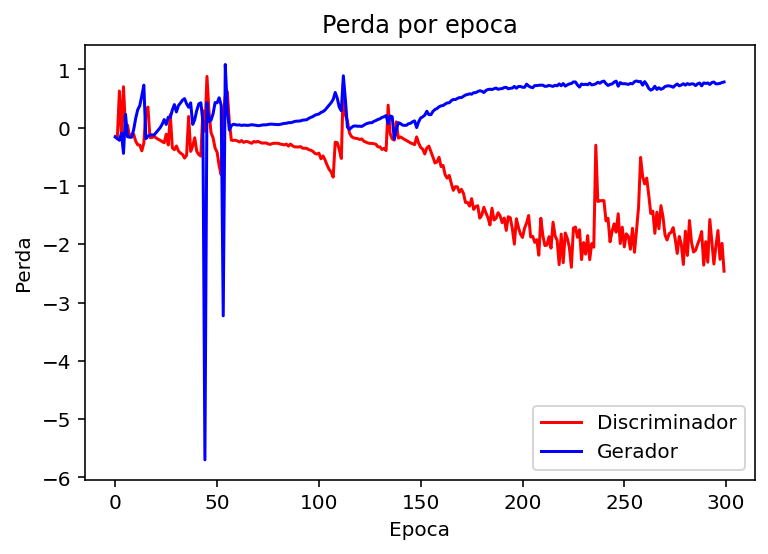

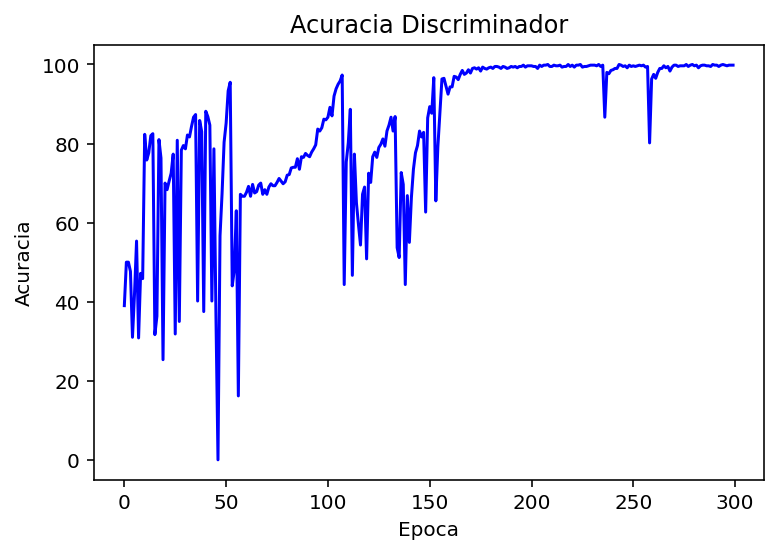

In [123]:
if __name__ == '__main__':
    midi = MIDI(tam_sequencia=300)
    model = MODEL(midi_obj=midi, dimensao_latente=300)
    model.Treinar(300, músicas=músicas, batch_size=300, intervalo_amostragem=1)
    Plotar('log', model.disc_loss, model.gen_loss, model.acuracia)

### Modelo B - Arquitetura ampliada com inserção de camadas de regularização (BatchNormalization) e camadas Densas

200 / 200 [Perda Discriminador: 0.686647, Acurácia: 46.75%] [Perda Gerador: 0.770279]
Tempo restante: 00:00:01 


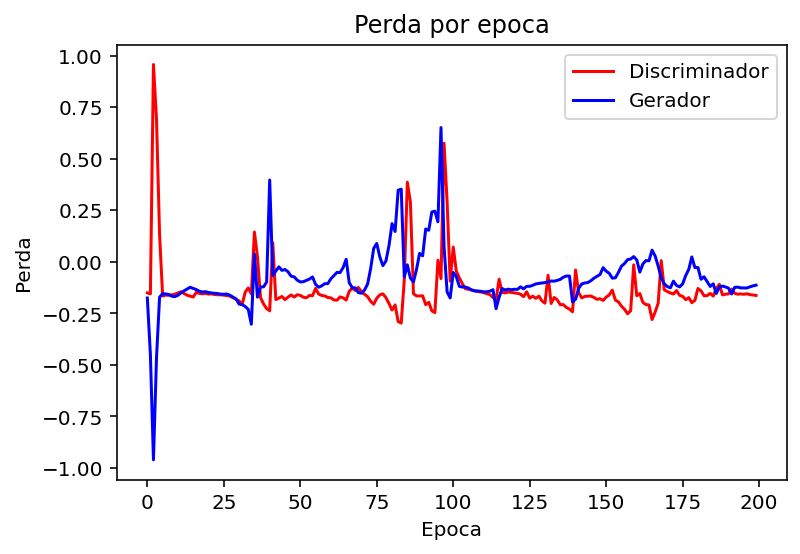

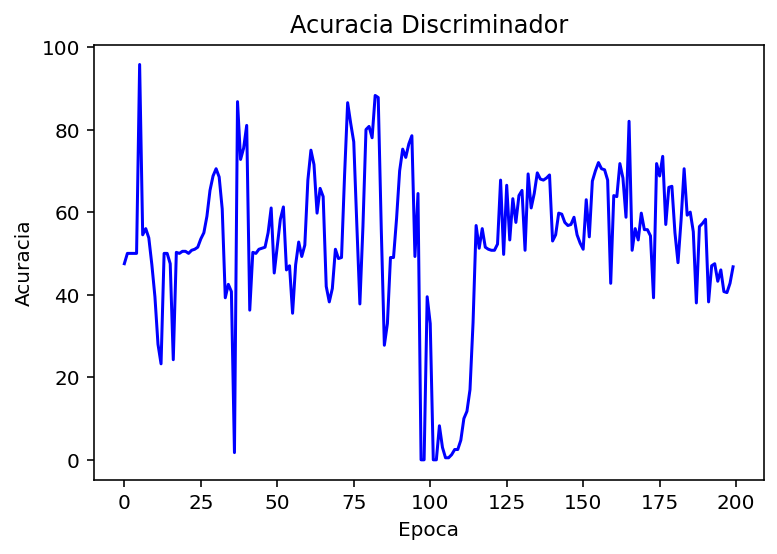

In [59]:
if __name__ == '__main__':
    midi = MIDI(tam_sequencia=100)
    model = MODEL(midi_obj=midi, dimensao_latente=100)
    model.Treinar(200, músicas=músicas, batch_size=200, intervalo_amostragem=1)
    Plotar('log', model.disc_loss, model.gen_loss, model.acuracia)

### Modelo C - Incluindo critério de halting temporário de treinamento

200 / 200 [Perda Discriminador: 0.274016, Acurácia: 86.17%] [Perda Gerador: 0.077929]
Tempo restante: 00:00:02 


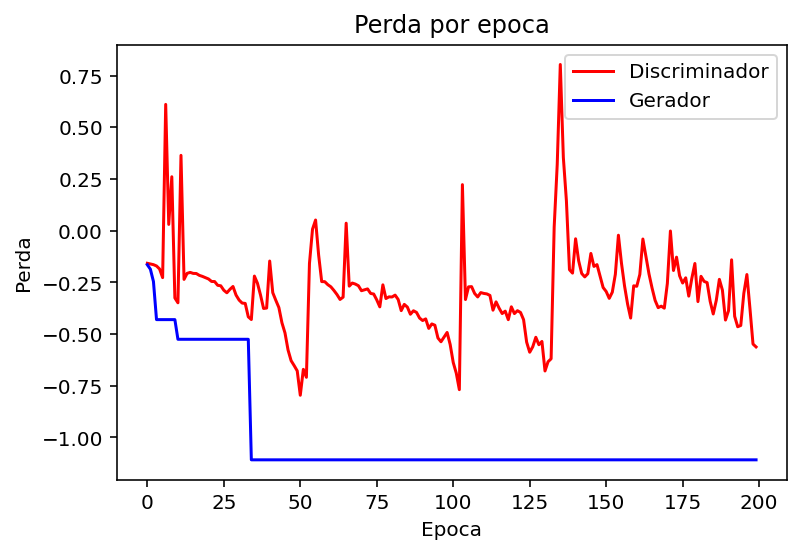

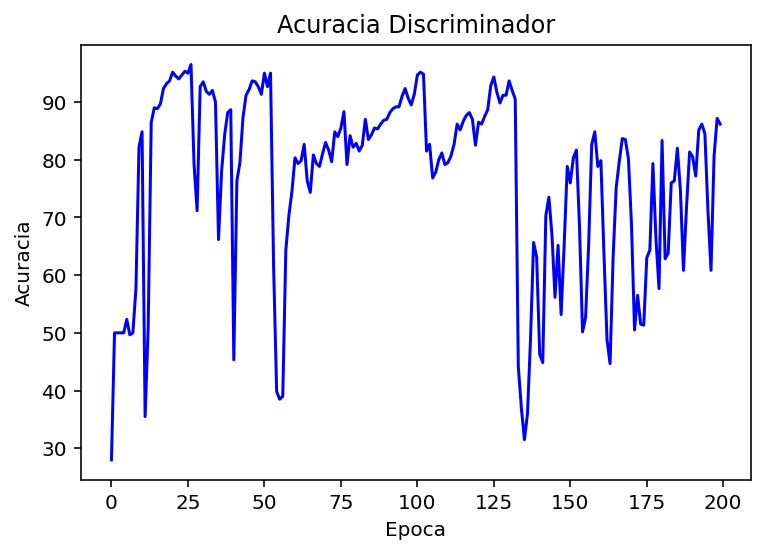

In [98]:
if __name__ == '__main__':
    midi = MIDI(tam_sequencia=300)
    model = MODEL(midi_obj=midi, dimensao_latente=100)
    model.Treinar(200, músicas=músicas, batch_size=300, intervalo_amostragem=1)
    Plotar('log', model.disc_loss, model.gen_loss, model.acuracia)

### Modelo D - Ajustando tamanho da sequência observada por amostra e Learning Rate

300 / 300 [Perda Discriminador: 0.002818, Acurácia: 100.00%] [Perda Gerador: 0.000119]
Tempo restante: 00:00:02 


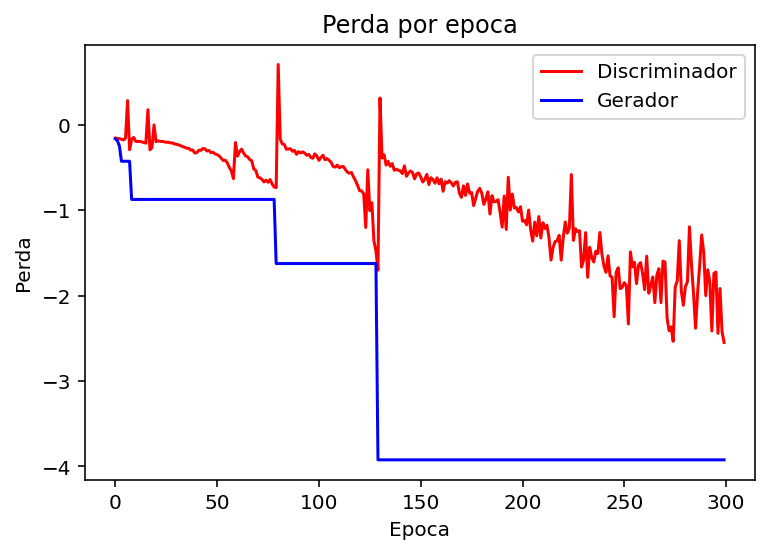

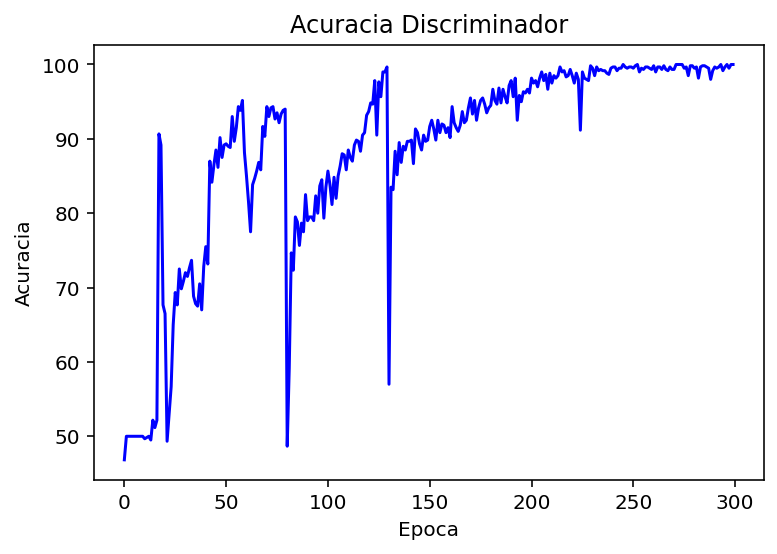

In [99]:
if __name__ == '__main__':
    midi = MIDI(tam_sequencia=300)
    model = MODEL(midi_obj=midi, dimensao_latente=300)
    model.Treinar(300, músicas=músicas, batch_size=300, intervalo_amostragem=1)
    Plotar('log', model.disc_loss, model.gen_loss, model.acuracia)

In [ ]:
Gerar("Resultado", model.latent_dim, model.gerador, midi.codificacao_notas)